# ECG classification

Laurent Cetinsoy - Datadidacte


In [1]:
from IPython.display import HTML

## A first naive model by extracting simple features


Your environment contains variables arr, nsr, and chf which respectively contain 10-second recordings of ECG signals extracted from three datasets on PhysioNet: one from a person suffering from arrhythmia, one from a person with a normal heart rhythm, and another from a person with heart failure.


Matplotlib  subplots (or any other library), display these signals on three subfigures (the subplots should be called with the parameter nrows = 3).
Can you find any differences between them?

In [2]:
import numpy as np
import os

data_dir = 'data/'

arr = np.loadtxt(os.path.join(data_dir, 'arr.txt'))
chf = np.loadtxt(os.path.join(data_dir, 'chf.txt'))
nsr = np.loadtxt(os.path.join(data_dir, 'nsr.txt'))

We want to extract features from the time series. For that we will use simple statistics.


Create a function named calculate_stats_features(x) that calculates some statistical features of a signal x using standard numpy functions: nanpercentile, nanmean, etc.
calculate_stats_features will return a list of features in this order:

0. Max
1. Min
2. Mean
3. Median
4. Variance

In [3]:
def calculate_stats_features(x):
    features = []
    features.append(np.max(x))
    features.append(np.min(x))
    features.append(np.mean(x))
    features.append(np.median(x))
    features.append(np.var(x))
    return features

for x in [arr, chf, nsr]:
    print(calculate_stats_features(x))

[np.float64(1.375), np.float64(-0.59), np.float64(-0.3120111111111112), np.float64(-0.335), np.float64(0.039663552654320984)]
[np.float64(1.235), np.float64(-1.79), np.float64(-0.363622), np.float64(-0.375), np.float64(0.15541165111599997)]
[np.float64(2.965), np.float64(-0.785), np.float64(-0.035453124999999995), np.float64(-0.145), np.float64(0.21755463842773434)]




Create a function named `calculate_zero_crossing(x)` that calculates the Zero
Crossing of a signal x.

The zero crossing is defined as the number of times the signal changes sign.
For this, you can use the signbit, diff, and nonzero functions from numpy.


In [4]:
def calculate_zero_crossing(x):
    y = x[np.nonzero(x)]
    return len(np.where(np.diff(np.sign(y)))[0])

x = np.array([1, 2, 3, -1, -2, -3, 0, 0, 0, 0, -1])
calculate_zero_crossing(arr)

22

Create a function named **calculate_rms(x)** that returns the Root Mean Square (RMS) of a signal x. We will use the nanmean function instead of the mean function from numpy.

In [5]:
def calculate_rms(x):
    return np.sqrt(np.mean(np.square(x)))

print(calculate_rms(arr))

0.37015467862923346


Create a function named calculate_entropy(x) that calculates the Shannon entropy of a signal x using the entropy function from scipy.stats.

In [8]:
from scipy.stats import entropy

def calculate_entropy(x):
    _,counts = np.unique(x, return_counts=True)
    return entropy(counts)

print(calculate_entropy(nsr))

3.9597588364931857


Create a function get_features(x) that combines the features calculated by all previous functions including caculate_stats_features.

In [9]:
def get_features(x):
    features = []
    features.extend(calculate_stats_features(x))
    features.append(calculate_zero_crossing(x))
    features.append(calculate_rms(x))
    features.append(calculate_entropy(x))
    return features

print(get_features(arr))

[np.float64(1.375), np.float64(-0.59), np.float64(-0.3120111111111112), np.float64(-0.335), np.float64(0.039663552654320984), 22, np.float64(0.37015467862923346), np.float64(4.444550643807692)]


Load the small ecg dataset
Use your fonction get_features create a new dataframe where you have all the feature as X and y as the label.
Train a random forest on it after doing a train test split if the dataset is not too small

In [10]:
import pandas as pd

def get_dataset(pathname):
    df = pd.read_csv(pathname)
    df.drop(df.columns[0],axis=1, inplace=True)
    X = df.drop(df.columns[0],axis=1)
    y = df[df.columns[0]]
    X = list(map(lambda x: get_features(x), np.array(X)))
    return X, y

X, y = get_dataset(os.path.join(data_dir, 'ecg_small_dataset.csv'))

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.0


Now you have a first pipeline, do the same on the full dataset
Report the train and test loss

In [12]:
X, y = get_dataset(os.path.join(data_dir, 'ECG-laurent.csv'))

/tmp/ipykernel_22815/3548531644.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pathname)


In [13]:
y.value_counts()

1
1    96
0    36
2    30
Name: count, dtype: int64

In [45]:
from sklearn.metrics import classification_report

def train_test(X, y, classifier):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    classifier = classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    y_pred = classifier.predict(X_test)
    print("test score: ", score)
    print(classification_report(y_test, y_pred))
    return classifier

In [46]:
clf = RandomForestClassifier(n_estimators=10)
train_test(X, y, clf)

test score:  0.8484848484848485
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.82      0.95      0.88        19
           2       0.67      0.33      0.44         6

    accuracy                           0.85        33
   macro avg       0.83      0.76      0.77        33
weighted avg       0.83      0.85      0.83        33



RandomForestClassifier(n_estimators=10)

try to tweak the model hyperparameter to see if it works

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 50, 100], 
         'max_depth': [ 10, 50, 100],
         'max_features': ['sqrt', 'log2'],
         'class_weight': ['balanced', None]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'class_weight': None, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 50}


In [49]:
clf = RandomForestClassifier(**grid_search.best_params_)
train_test(X, y, clf)

test score:  0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.90      0.95      0.92        19
           2       0.80      0.67      0.73         6

    accuracy                           0.91        33
   macro avg       0.90      0.87      0.88        33
weighted avg       0.91      0.91      0.91        33



RandomForestClassifier(max_depth=100, n_estimators=50)

The grid search did find some better hyperparameter but the initialisation of the search is random and therefore does not give the same hyperparameter every time.

## Fourier transform features

We want now to see if a model using only fourier transform could work.

create a function get_fourier_coefficients(ecg)

In [17]:
def get_fourrier_coefficients(x):
    fourier_coeff = np.fft.fft(x)
    return np.real(fourier_coeff)

Using this function create a dataframe df_fourrier containing the fourrier transform coefficients and the label

In [19]:
def df_to_fourier(pathname):
    df = pd.read_csv(pathname)
    df.drop(df.columns[0],axis=1, inplace=True)
    X = df.drop(df.columns[0],axis=1)
    y = df[df.columns[0]]
    X = list(map(lambda x: get_fourrier_coefficients(x), np.array(X)))
    return X, y

Xf, yf = df_to_fourier(os.path.join(data_dir, 'ECG-laurent.csv'))

/tmp/ipykernel_22815/3043631260.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pathname)


In [29]:
df = pd.read_csv(os.path.join(data_dir, 'ECG-laurent.csv'))

/tmp/ipykernel_22815/1258075916.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_dir, 'ECG-laurent.csv'))


Try to train a model using the Fourrier coefficient

In [52]:
clf = RandomForestClassifier(**grid_search.best_params_)
train_test(Xf, yf, clf)

test score:  0.5757575757575758
              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.59      0.84      0.70        19
           2       0.00      0.00      0.00         6

    accuracy                           0.58        33
   macro avg       0.45      0.41      0.40        33
weighted avg       0.52      0.58      0.52        33



RandomForestClassifier(max_depth=100, n_estimators=50)

Try to learn a model using both fourrier coefficient and the features from the previous sections. Does it work ?

In [88]:
#concatenate the two datasets
X_np = np.array(X)
Xf_np = np.array(Xf)
X_all = np.concatenate((X_np, Xf_np), axis=1)
y_all = np.array(y)

print("X shape: ", X_np.shape, "Xf shape: ", Xf_np.shape, "X_all shape: ", X_all.shape)

X shape:  (162, 8) Xf shape:  (162, 65536) X_all shape:  (162, 65544)


In [89]:
clf = RandomForestClassifier(n_estimators=10)
train_test(X_all, y_all, clf)

test score:  0.5151515151515151
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.62      0.68      0.65        19
           2       0.00      0.00      0.00         6

    accuracy                           0.52        33
   macro avg       0.34      0.39      0.36        33
weighted avg       0.45      0.52      0.48        33



RandomForestClassifier(n_estimators=10)

## Wavelets

In [58]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 2.5 MB/s eta 0:00:0000:0100:01


We now wants to use another signal decomposition which are called wavelet. Wavelet are a multi-scale function decomposition on a familly of functions generated from what is called a mother wavelet.

Using PyWavelet make a function get_wavelet_coefficients(ecg) that returns the wavelet coefficient of a given ECG


In [83]:
import pywt

def get_wavelet_coefficients(x):
    wavelet_coeff = pywt.wavedec(x, 'db1', level=3)
    return np.concatenate(wavelet_coeff)

Using the get_wavelet_coefficients, create a dataframe when the features are the coefficients and include the label

In [69]:
df = pd.read_csv(os.path.join(data_dir, 'ECG-laurent.csv'))

/tmp/ipykernel_22815/1258075916.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_dir, 'ECG-laurent.csv'))


In [71]:
df.drop([df.columns[0], df.columns[1]],axis=1, inplace=True)

In [82]:
len(pywt.dwt(df.iloc[0], 'db1')[0])

32770

In [84]:
def df_to_wavelet(pathname):
    df = pd.read_csv(pathname)
    df.drop(df.columns[0],axis=1, inplace=True)
    X = df.drop(df.columns[0],axis=1)
    y = df[df.columns[0]]
    X = list(map(lambda x: get_wavelet_coefficients(x), np.array(X)))
    return X, y

Train a random forest classifier with such features. DOes the model work

In [91]:
Xw, yw = df_to_wavelet(os.path.join(data_dir, 'ECG-laurent.csv'))

/tmp/ipykernel_22815/2082789351.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pathname)


In [92]:
clf = RandomForestClassifier(n_estimators=10)
train_test(Xw, yw, clf)

test score:  0.6363636363636364
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.67      0.84      0.74        19
           2       0.50      0.17      0.25         6

    accuracy                           0.64        33
   macro avg       0.58      0.50      0.51        33
weighted avg       0.61      0.64      0.60        33



RandomForestClassifier(n_estimators=10)

It seems to work better than using Fourrier transform.

Add one or several of the previous feature functions and try to train another model

In [93]:
Xw_np = np.array(Xw)
X_all_w = np.concatenate((X_np[:, :2], Xw_np), axis=1)

# take 2 features from the first feature set
print("X shape: ", X_np[:, :2].shape, "Xw shape: ", Xw_np.shape, "X_all_w shape: ", X_all_w.shape)

clf = RandomForestClassifier(n_estimators=10)
train_test(X_all_w, y_all, clf)

X shape:  (162, 2) Xw shape:  (162, 65536) X_all_w shape:  (162, 65538)
test score:  0.696969696969697
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.69      0.95      0.80        19
           2       0.00      0.00      0.00         6

    accuracy                           0.70        33
   macro avg       0.47      0.52      0.49        33
weighted avg       0.57      0.70      0.62        33



/home/gautier/python_venv/ml_bio/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gautier/python_venv/ml_bio/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gautier/python_venv/ml_bio/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

RandomForestClassifier(n_estimators=10)

Specify the methodology you used to train the model and report the various attempts results into a table

## Deep learning (1D CNN)

Now we want to see if we can skip all theses feature engineering techniques !
Design and train a multi-layer one dimensional CNN using the raw ECG signal as features.


Could you reach or surpass the feature based models ?

In [95]:
!pip install tensorflow

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached grpcio-1.68.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 2.0 MB/s eta 0:00:0000:0100:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
Using cached grpcio-1.68.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [142]:
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.preprocessing import OneHotEncoder


def get_XY_raw(pathname):
    df = pd.read_csv(pathname)
    df.drop(df.columns[0],axis=1, inplace=True)
    X = df.drop(df.columns[0],axis=1)
    y = df[df.columns[0]].to_numpy().reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(y)

    return np.array(X), one_hot_encoded


def get_cnn_model(input_shape, output_shape=3):
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    return model

X_raw, y_raw = get_XY_raw(os.path.join(data_dir, 'ECG-laurent.csv'))
model = get_cnn_model((X_raw.shape[1], 1))
model.summary()

/tmp/ipykernel_22815/1609151605.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pathname)
/home/gautier/python_venv/ml_bio/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 65536, 16)      │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 32768, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 32768, 32)      │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 16384, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 16384, 64)      │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 8192, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │    67,108,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,122,371 (256.05 MB)

 Trainable params: 67,122,371 (256.05 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
X_raw = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)
X_raw.shape

(162, 65536, 1)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_test = np.argmax(y_test, axis=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.6195 - loss: 0.5388 - val_accuracy: 0.6061 - val_loss: 0.5273
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.7143 - loss: 0.5028 - val_accuracy: 0.5758 - val_loss: 0.5025
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.6398 - loss: 0.4593 - val_accuracy: 0.5758 - val_loss: 0.5164
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.6207 - loss: 0.4868 - val_accuracy: 0.5152 - val_loss: 0.5614
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.7850 - loss: 0.4689 - val_accuracy: 0.5758 - val_loss: 0.4971
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.6380 - loss: 0.4836 - val_accuracy: 0.5758 - val_loss: 0.4922
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.6536 - loss: 0.4223 - val_accuracy: 0.6061 - val_loss: 0.4630
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.8084 - loss: 0.3937 - val_accuracy: 0.5758 - val_loss:

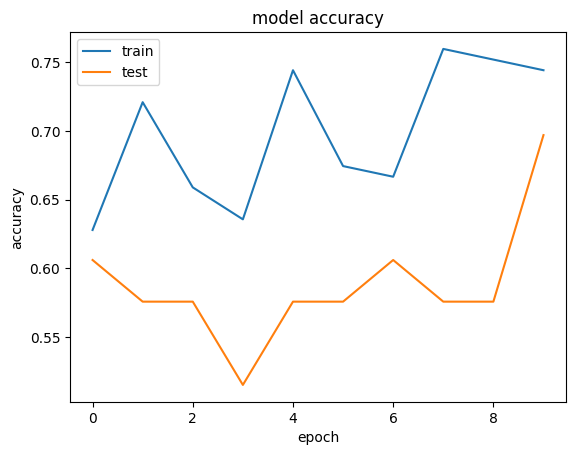

In [149]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [150]:
y_label = model.predict(X_test)
y_label = np.argmax(y_label, axis=1)
print(classification_report(y_test, y_label, zero_division=0))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       0.78      0.74      0.76        19
           2       1.00      0.17      0.29         6

    accuracy                           0.70        33
   macro avg       0.78      0.63      0.59        33
weighted avg       0.77      0.70      0.66        33



Random forest is still better with some features ingineering